# This is the simpliest pipeline of Fian.

## There are 3 phases

- Intent Detection a.k.a NLP layers

- Feature Selection

- Respond

# Phase 1 - Intent Detection

1. Input Preprocessing

1. Extract user's intent (using TF-IDF + Logistic Regression)

First, for good measure, I will train the model first (train it once and give out a joblib file, but they are here for visualizations)

P.S: If you are seeing model and such, means that the part is under developement

Second, I will use the model to predict what's the user's intent


In [11]:
import spacy
import spacy_transformers

print("spaCy loaded.")
print("Transformers module:", spacy_transformers)
nlp = spacy.load("en_core_web_trf")
print("Transformer model loaded successfully.")


ModuleNotFoundError: No module named 'spacy'

In [80]:
# NLP SpaCy "en_core_web_trf"
import re
import spacy
import yfinance as yf
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nlp = spacy.load("en_core_web_trf")
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

## == == == -- -- -- Helper Functions -- -- -- == == == ##

def preprocess_query(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return ' '.join(tokens)


def run_NER(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

def extract_entities(entities, label):
    return [ent_text for ent_text, ent_label in entities if ent_label == label]

def to_yf_period(text):
    match = re.search(r'(\d+)\s*(year|years|month|months|week|weeks|day|days)', text, re.IGNORECASE)
    if match:
        number = match.group(1)
        unit = match.group(2).lower()

        if 'year' in unit:
            return f"{number}y"
        elif 'month' in unit:
            return f"{number}mo"
        elif 'week' in unit:
            days = int(number) * 7
            return f"{days}d"
        elif 'day' in unit:
            return f"{number}d"
    return None

def yfinance_search_company(company_names):
    results = {}
    for name in company_names:
        s = yf.Search(name, max_results=1)
        if s.quotes:
            results[name] = s.quotes[0].get("symbol")
        else:
            results[name] = None
    # Return a list of ticker symbols (filtering out any None values)
    return [ticker for ticker in results.values() if ticker]

## == == == -- -- -- Main Execute Functions -- -- -- == == == ##
def extract_tickers(text):
    entities = run_NER(text)
    company_names = extract_entities(entities, "ORG")
    tickers = yfinance_search_company(company_names)
    return tickers

def extract_intent(text):
    result = "show_infos"
    return result

def extract_period(text):
    entities = run_NER(text)
    date_entities = extract_entities(entities, "DATE")

    if len(date_entities) >= 2: 
        print("Multiple Date Ranges are not compatible YET. I will add later. Default: max") 
        return "max"

    if len(date_entities) == 1:
        period = to_yf_period(text)
        if period:
            return period
        else:
            return "max"  

    return "max"


raw_query = "What's the stock of Apple and Nvidia and Microsoft in the past 3 years?"

intent = extract_intent(raw_query)
period = extract_period(raw_query)
tickers = extract_tickers(raw_query)

print(intent) # Not implemented, Default: show_infos
print(period)
print(tickers)





show_infos
3y
['AAPL', 'NVDA', 'MSFT']


[*********************100%***********************]  1 of 1 completed


=== First 10 rows ===
Price            Close        High         Low        Open     Volume
Ticker            NVDA        NVDA        NVDA        NVDA       NVDA
Date                                                                 
2024-06-07  120.848289  121.652026  117.983234  119.730653  412386000
2024-06-10  121.749992  123.059560  116.971564  120.330461  314162700
2024-06-11  120.880211  122.839727  118.710740  121.739992  222551200
2024-06-12  125.169144  126.848730  122.539795  123.029672  299595000
2024-06-13  129.578064  129.768020  127.128671  129.358117  260704500
2024-06-14  131.847519  132.807274  128.288398  129.927994  309320400
2024-06-17  130.947739  133.697061  129.548090  132.957253  288504400
2024-06-18  135.546600  136.296416  130.657806  131.107692  294335100
2024-06-20  130.747772  140.725309  129.488088  139.765554  517768400
2024-06-21  126.538811  130.597815  124.269373  127.088678  655484700


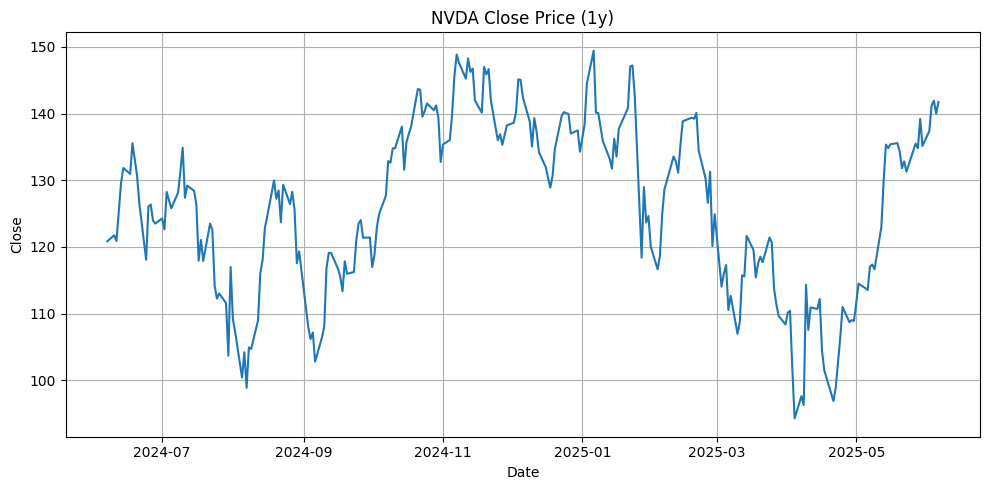

Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2024-06-07,120.848289,121.652026,117.983234,119.730653,412386000
2024-06-10,121.749992,123.059560,116.971564,120.330461,314162700
2024-06-11,120.880211,122.839727,118.710740,121.739992,222551200
2024-06-12,125.169144,126.848730,122.539795,123.029672,299595000
2024-06-13,129.578064,129.768020,127.128671,129.358117,260704500
...,...,...,...,...,...
2025-06-02,137.380005,138.119995,135.399994,135.490005,197663100
2025-06-03,141.220001,142.000000,137.949997,138.779999,225578800


In [ ]:
# show_infos function
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

## == == == -- -- -- Helper Functions -- -- -- == == == ##

def extract_data_yf(ticker, Period = "1y"):
    df = yf.download(ticker, period=Period, interval="1d")
    return df

def display_stock(df, n_rows: int = 10):

    print(f"=== First {n_rows} rows ===")
    print(df.head(n_rows).to_string())
    # print(f"\n=== Last {n_rows} rows ===")
    # print(df.tail(n_rows).to_string())
    # print("\n=== Descriptive Statistics ===")
    # print(df.describe().round(2).to_string())

def line_graph(df, field: str = "Close", title: str = None):

    plt.figure(figsize=(10, 5))
    plt.plot(df.index, df[field])
    plt.xlabel("Date")
    plt.ylabel(field)
    plt.title(title or f"{field} Price Over Time")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## == == == -- -- -- Main Execute Function -- -- -- == == == ##

def show_infos(ticker: str, period: str = "1y", visual: bool = True):

    # 1) Fetch the data
    df = extract_data_yf(ticker, period)

    # 2) Print a table summary
    display_stock(df)

    # 3) Plot if requested
    if visual:
        line_graph(df, title=f"{ticker.upper()} Close Price ({period})")

    return df





In [ ]:
if intent == "show_infos":
    period = extract_period(raw_query)
    tickers = extract_tickers(raw_query)
    show_infos(tickers, )


